In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder


train = pd.read_csv("/kaggle/input/playground-series-s5e1/train.csv")  
test = pd.read_csv("/kaggle/input/playground-series-s5e1/test.csv") 

In [2]:
train.describe()

,id,num_sold
count,230130.000000,221259.000000
mean,115064.500000,752.527382
std,66432.953062,690.165445
min,0.000000,5.000000
25%,57532.250000,219.000000
50%,115064.500000,605.000000
75%,172596.750000,1114.000000
max,230129.000000,5939.000000


In [3]:
train =train.dropna()

In [4]:

# Iterate through each column and print the number of unique values
for col in train.columns:
    print(f"Column '{col}' has {train[col].nunique()} unique values.")

Column 'id' has 221259 unique values.
Column 'date' has 2557 unique values.
Column 'country' has 6 unique values.
Column 'store' has 3 unique values.
Column 'product' has 5 unique values.
Column 'num_sold' has 4037 unique values.


(array([71531.,     0.,     0.,     0.,     0., 74044.,     0.,     0.,
            0., 75684.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

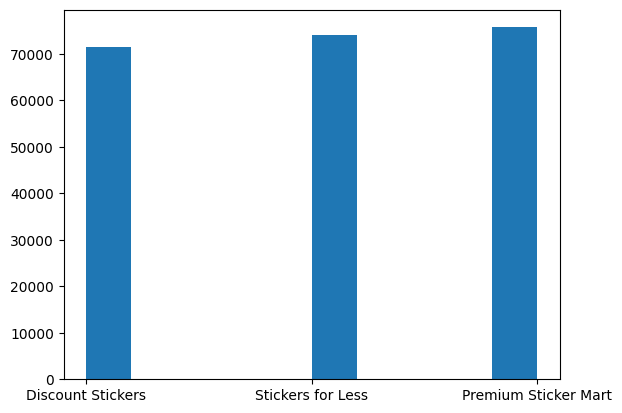

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(train["store"])

(array([46026.,     0., 46026.,     0.,     0., 45962.,     0., 46025.,
            0., 37220.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

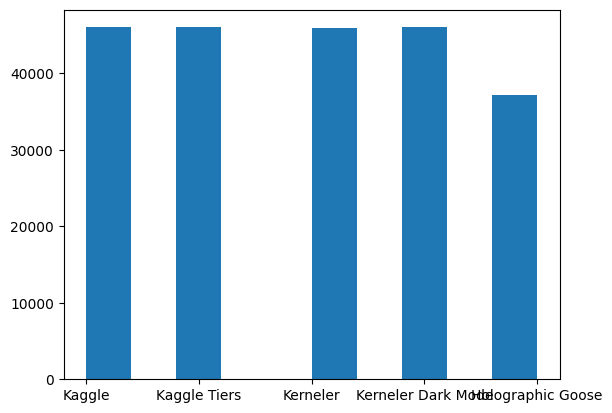

In [6]:
plt.hist(train["product"])

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

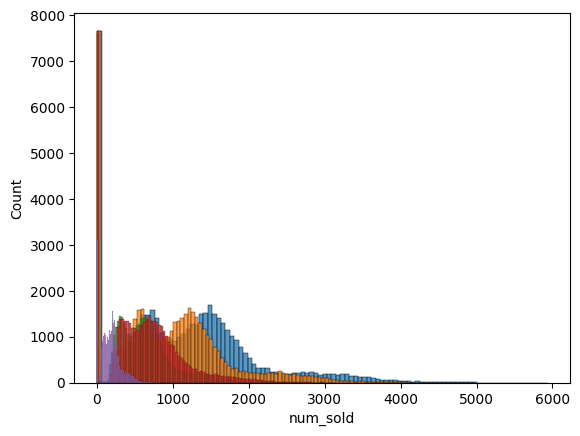

In [7]:
for i in train['product'].unique():
    sns.histplot(data=train[train['product'] == i], x='num_sold')

In [8]:
from sklearn.preprocessing import LabelEncoder

for col in train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])

for col in test.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    test[col] = le.fit_transform(test[col])


In [9]:
# Extract date features 

df = train
df['date'] = pd.to_datetime(df['date'])


df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
df['day_of_year'] = df['date'].dt.dayofyear  # Helps capture annual seasonality
df['week_of_year'] = df['date'].dt.isocalendar().week
df['days_since_start'] = (df['date'] - df['date'].min()).dt.days

In [10]:
# check for any outliers in num_sold & eliminate them by taking log

#cCalculate Q1 (25th percentile), Q3 (75th percentile), and IQR
Q1 = np.percentile(train['num_sold'], 25)
Q3 = np.percentile(train['num_sold'], 75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = train['num_sold'][(train['num_sold'] < lower_bound) | (train['num_sold'] > upper_bound)]

print(f"Outliers: {outliers}")
outliers_sum = np.sum(outliers)

df['num_sold_log'] = np.log1p(df['num_sold'])  # Log transformation

Outliers: 66        3369.0
67        3195.0
71        3940.0
72        3430.0
156       3545.0
           ...  
230066    2481.0
230106    2767.0
230111    3459.0
230112    2735.0
230126    2907.0
Name: num_sold, Length: 6630, dtype: float64


In [11]:
# Using K-means for searching any patters or clusters for independent features

from sklearn.cluster import KMeans

# Select features for clustering
features_for_clustering = df[[ 'days_since_start', 'month', 'day_of_week', 
                              'country', 'store', 'product']]

kmeans = KMeans(random_state=42)
df['cluster'] = kmeans.fit_predict(features_for_clustering)

print(df[['num_sold', 'cluster']].head())

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   num_sold  cluster
1     973.0        6
2     906.0        1
3     423.0        1
4     491.0        1
5     300.0        6


In [12]:
from xgboost import XGBRegressor

# Drop the original 'date' column (since we've extracted useful features)
X_train = df.drop(columns=['date','num_sold', 'num_sold_log'])
y_train = df['num_sold_log']


# Train-test split (time series: no shuffle)
# Split the data chronologically (the test set comes after the training set)
train_size = int(len(X_train) * 0.8)
X_train, X_val = X_train[:train_size], X_train[train_size:]
y_train, y_val = y_train[:train_size], y_train[train_size:]

# Initialize and train the XGBoost model
model = XGBRegressor()
model.fit(X_train, y_train)

# Make predictions on the test set (using only features, no lag)
test_predictions = model.predict(X_val)

from sklearn.metrics import mean_squared_error


rmse = np.sqrt(mean_squared_error(y_val, test_predictions))

# Print the predictions for the test set
rmse

0.16358073386136823

In [13]:
# pre processing for test data

df = test
df['date'] = pd.to_datetime(df['date'])


df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
df['day_of_year'] = df['date'].dt.dayofyear  # Helps capture annual seasonality
df['week_of_year'] = df['date'].dt.isocalendar().week
df['days_since_start'] = (df['date'] - df['date'].min()).dt.days

# Select features for clustering
features_for_clustering = df[[ 'days_since_start', 'month', 'day_of_week', 
                              'country', 'store', 'product']]

kmeans = KMeans(random_state=42)
df['cluster'] = kmeans.fit_predict(features_for_clustering)

test = df.drop(columns = ['date'])



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [14]:
num_sold = model.predict(test)
num_sold = np.expm1(num_sold)

submission = pd.read_csv('/kaggle/input/playground-series-s5e1/sample_submission.csv')
submission['num_sold'] = num_sold
submission['num_sold'] = submission['num_sold'].astype(int)

submission

,id,num_sold
0,230130,83
1,230131,678
2,230132,554
3,230133,313
4,230134,280
...,...,...
98545,328675,246
98546,328676,1935
98547,328677,1689
98548,328678,963


In [15]:
submission.to_csv("output_file.csv", index=False)